# 7.5 提升法

提升法（boosting，最初被称为假设提升）是指可以将几个弱学习器结合成一个强学习器的任意集成方法。大多数提升法的总体思路是循环训练预测器，每一次都对其前序做出一些改正。

## 7.5.1 AdaBoost

新预测器对其前序进行纠正的方法之一就是更多地关注前序欠拟合的训练实例，从而使新的预测器不断地越来越专注于难缠的问题，这就是AdaBoost使用的技术。例如，当训练AdaBoost分类器时，该算法首先训练一个基础分类器（例如决策树），并使用它对训练集进行预测。然后，该算法会增加分类错误的训练实例的相对权重。然后，它使用更新后的权重训练第二个分类器，并再次对训练集进行预测，更新实例权重，以此类推（见图7-7）。

![fig 7-7](./images/fig_7-7.png)

图7-7:AdaBoost循环训练，实例权重不断更新


In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

# use ggplot style
plt.style.use('ggplot')

In [2]:
# 定义一个会议决策边界的方法
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-2, 3, -1.5, 2], alpha=0.5, contour=False):
    x1s = np.linspace(axes[0], axes[1], num=100)
    x2s = np.linspace(axes[2], axes[3], num=100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap2)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], 'yo', alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], 'bs', alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r'$x_1$', fontsize=14)
    plt.ylabel(r'$x_2$', fontsize=14)



In [3]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=500, noise=0.40, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
from matplotlib import font_manager
fontP = font_manager.FontProperties(fname="./../fonts/Arial Unicode.ttf")
fontP.set_size(14)

In [5]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), 
    n_estimators=200,
    algorithm="SAMME.R", 
    learning_rate=0.5, 
    random_state=42)

ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

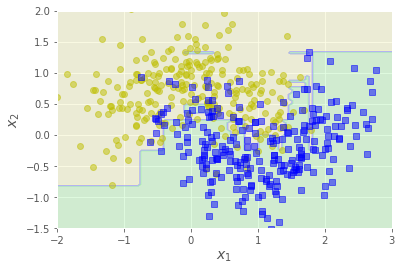

In [6]:
plot_decision_boundary(ada_clf, X, y)
# plt.title("AdaBoost Classifier")
plt.show()

虽然SVM并不适合作为AdaBoostClassifier的基本预测器，这是由于SVM不仅比较慢，而且趋于不稳定。下面的代码只是使用SVM来演示AdaBoost的训练过程

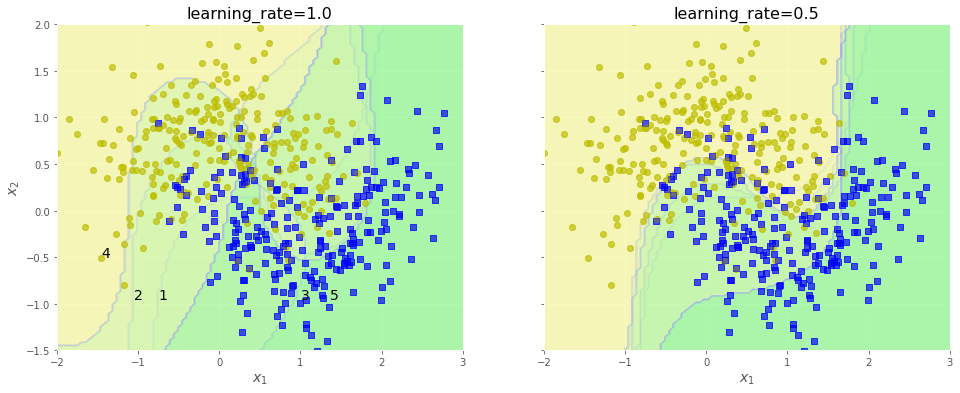

In [9]:
from sklearn.svm import SVC

m = len(X_train)

fig, axes = plt.subplots(ncols=2, figsize=(16,6), sharey=True)

for subplot, learning_rate in zip([0, 1], [1.0, 0.5]):
    # 样本的采样权重
    sample_weights = np.ones(m)/m
    plt.sca(axes[subplot])
    # 这里使用SVM来演示的AdaBoost的5次迭代训练的过程
    for i in range(5):
        svm_clf = SVC(kernel='rbf', C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights*m)   #此时所有的训练样本的权重都为1.0
        y_pred = svm_clf.predict(X_train)

        # 计算一下拟合失败的样本
        r = sample_weights[y_pred != y_train].sum() / sample_weights.sum()
        alpha = learning_rate * np.log((1-r)/r)
        sample_weights[y_pred != y_train] *= np.exp(alpha)
        sample_weights /= sample_weights.sum()

        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate={}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=14)
        plt.text(-1.05, -0.95, "2", fontsize=14)
        plt.text(1.0, -0.95, "3", fontsize=14)
        plt.text(-1.45, -0.5, "4", fontsize=14)
        plt.text(1.36,  -0.95, "5", fontsize=14)
    else:
        plt.ylabel("")

plt.show()


第一个分类器产生了许多错误实例，所以这些实例的权重得到提升。因此第二个分类器在这些实例上的表现有所提升，然后第三个、第四个……右图绘制的是相同预测器序列，唯一的差别在于学习率减半（即每次迭代仅提升一半错误分类的实例的权重）。可以看出，AdaBoost这种依序循环的学习技术跟梯度下降有一些异曲同工之处，差别只在于——不再是调整单个预测器的参数使成本函数最小化，而是不断在集成中加入预测器，使模型越来越好。

旦全部预测器训练完成，集成整体做出预测时就跟bagging或pasting方法一样了，除非预测器有不同的权重，因为它们总的准确率是基于加权后的训练集。

**这种依序学习技术有一个重要的缺陷就是无法并行（哪怕只是一部分），因为每个预测器只能在前一个预测器训练完成并评估之后才能开始训练。因此，在扩展方面，它的表现不如bagging和pasting方法。**



AdaBoost算法的详细过程：

每个实例权重$w^{(i)}$最初设置为$\frac{1}{m}$， 那么第$j$个预测器的加权误差率为:
$$
r_j = \frac{_{\hat{y}_j^{(i)} \neq y^{(i)}}^{\sum_{i=1}^m w^{(i)}}}{\sum_{i=1}^m w^{(i)}}     \tag{7-1}
$$

预测器的权重$\alpha_j$通过公式7-2计算，其中$\eta$是学习率。预测器的准确率越高，其权重就越高。如果它只是随机猜测，则其权重接近于零。但是，如果大部分情况下它都是错的（也就是准确率比随机猜测还低），那么它的权重为负。

$$
\alpha_j = \eta \log{\frac{1-r_j}{r_j}}     \tag{7-2}
$$

AdaBoost算法使用公式7-3更新实例权重，从而提高了误分类实例的权重。

$$
w^{(i)} \leftarrow \begin{cases} w^{(i)},  &\text{如果 } \hat{y}_j^{(i)} = y^{(i)} \\
   w^{(i)}\exp(\alpha_j), &\text{如果 } \hat{y}_j^{(i)} \neq y^{(i)} \end{cases}        \tag{7-3}
$$

然后对所有实例权重重新归一化:即除以$\sum_{i=1}^m w^{(i)}$。

最后，使用更新后的权重训练一个新的预测器，然后重复整个过程（计算新预测器的权重，更新实例权重，然后对另一个预测器进行训练，等等）。当到达所需数量的预测器或得到完美的预测器时，算法停止。

预测的时候，AdaBoost就是简单地计算所有预测器的预测结果，并使用预测器权重αj对它们进行加权。最后，得到大多数加权投票的类就是预测器给出的预测类（见公式7-4）。

AdaBoost预测:

$$
\hat{y}(x) = _k^{\argmax} {_{\hat{y}_j(x)=k}^{\sum_{j=1}^N \alpha_j}} \tag{7-4}
$$

其中N是预测器的数量.

Scikit-Learn使用的其实是AdaBoost的一个多分类版本，叫作SAMME（基于多类指数损失函数的逐步添加模型)。当只有两类时，SAMME即等同于AdaBoost。此外，如果预测器可以估算类概率（即具有predict_proba（）方法），Scikit-Learn会使用一种SAMME的变体，称为SAMME.R（R代表“Real”），它依赖的是类概率而不是类预测，通常表现更好。

In [10]:
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), 
    n_estimators=200,
    algorithm="SAMME.R",
    learning_rate=0.5
)

ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

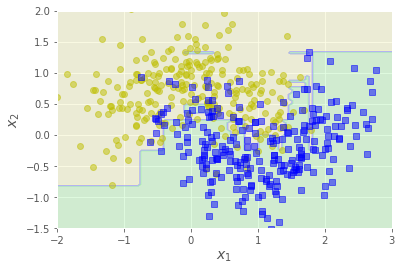

In [11]:
plot_decision_boundary(ada_clf, X, y)

**如果你的AdaBoost集成过度拟合训练集，你可以试试减少估算器数量，或是提高基础估算器的正则化程度。**

## 7.5.2 梯度提升

另一个非常受欢迎的提升法是梯度提升。与AdaBoost一样，梯度提升也是逐步在集成中添加预测器，每一个都对其前序做出改正。不同之处在于，它不是像AdaBoost那样在每个迭代中调整实例权重，而是让新的预测器针对前一个预测器的残差进行拟合。

我们来看一个简单的回归示例，使用决策树作为基础预测器（梯度提升当然也适用于回归任务），这被称为梯度树提升或者是梯度提升回归树（GBRT）。

In [13]:
# 1. 首先在数据集上训练一个回归树
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

from sklearn.tree import DecisionTreeRegressor
tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2)

In [14]:
# 针对第一个预测器的残差训练第二个回归树
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2)

In [15]:
# 针对第二个预测器训练第三个回归树
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2)

In [16]:
# 将三棵树相加，实现对实例的预测
X_new = [[0.8]]
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred

array([0.75026781])

图7-9的左侧表示这三棵树单独的预测，右侧表示集成的预测。第一行，集成只有一棵树，所以它的预测与第一棵树的预测完全相同。第二行是在第一棵树的残差上训练的一棵新树，从右侧可见，集成的预测等于前面两棵树的预测之和。类似地，第三行又有一棵在第二棵树的残差上训练的新树，集成的预测随着新树的添加逐渐变好。

In [17]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc='upper center', fontsize=16)
    plt.axis(axes)

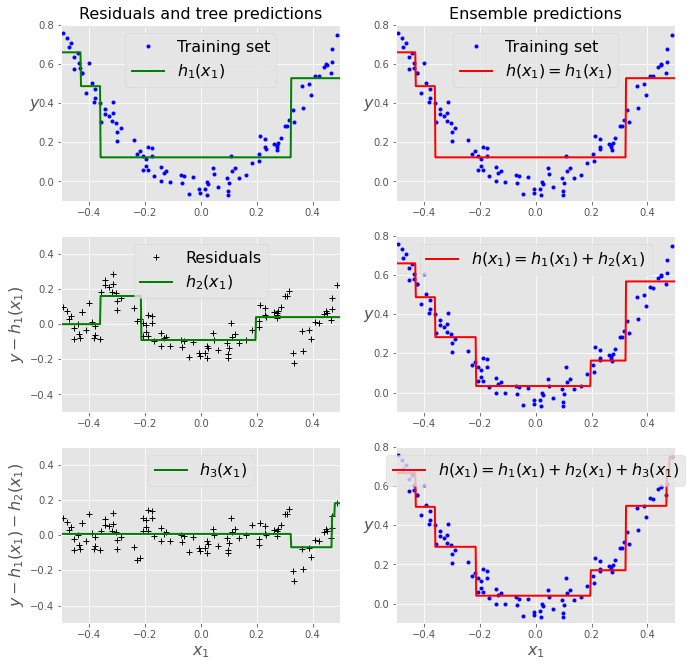

In [20]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label=r"$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel(r"$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

训练GBRT集成有个简单的方法，就是使用Scikit-Learn的GradientBoostingRegressor类。与RandomForestRegressor类似，它具有控制决策树生长的超参数（例如max_depth、min_samples_leaf等），以及控制集成训练的超参数，例如树的数量（n_estimators）。以下代码可创建上面的集成：

In [22]:
from sklearn.ensemble import GradientBoostingRegressor
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [23]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

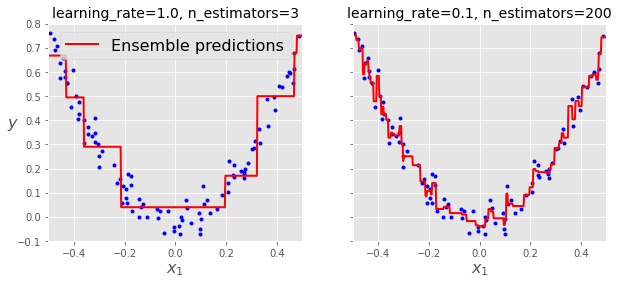

In [25]:

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

超参数learning_rate对每棵树的贡献进行缩放。如果你将其设置为低值，比如0.1，则需要更多的树来拟合训练集，但是预测的泛化效果通常更好，**这是一种被称为收缩的正则化技术**。上图显示了用低学习率训练的两个GBRT集成：左侧拟合训练集的树数量不足，而右侧拟合训练集的树数量过多从而导致过拟合。

### 提前停止

要找到树的最佳数量，可以使用**提前停止法（参见第4章）**。简单的实现方法就是使用`staged_predict（）`方法：它在训练的每个阶段（一棵树时，两棵树时，等等）都对集成的预测返回一个迭代器。以下代码训练了一个拥有120棵树的GBRT集成，然后测量每个训练阶段的验证误差，从而找到树的最优数量，最后使用最优树数重新训练了一个GBRT集成：

In [29]:
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors)+1
bst_n_estimators

56

In [30]:
gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=56, random_state=42)

In [32]:
min_error = np.min(errors)
min_error

0.002712853325235463

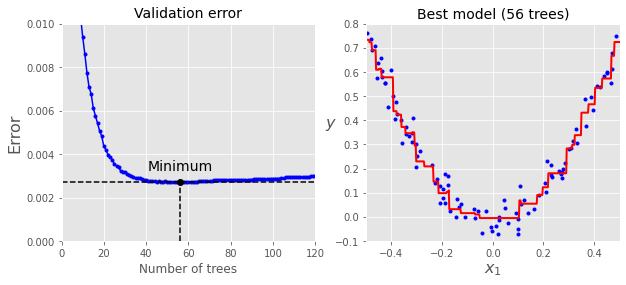

In [33]:

plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

实际上，要实现提前停止法，不一定需要先训练大量的树，然后再回头找最优的数字，还可以提前停止训练。设置`warm_start=True`，当`fit（）`方法被调用时，Scikit-Learn会保留现有的树，从而允许增量训练。以下代码会在验证误差连续5次迭代未改善时，直接停止训练：

In [34]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [35]:
print(gbrt.n_estimators)

61


In [36]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.002712853325235463


GradientBoostingRegressor类还可以支持超参数subsample，指定用于训练每棵树的实例的比例。例如，如果`subsample=0.25`，则每棵树用25%的随机选择的实例进行训练。现在你可以猜到，这也是用更高的偏差换取了更低的方差，同时在相当大的程度上加速了训练过程。**这种技术被称为随机梯度提升**。

### XGBoost

**值得注意的是，流行的Python库XGBoost（该库代表Extreme GradientBoosting）中提供了梯度提升的优化实现，该软件包最初是由Tianqi Chen作为分布式（深度）机器学习社区（DMLC）的一部分开发的，其开发目标是极快、可扩展和可移植。**

In [38]:
try:
    import xgboost
except ImportError as ex:
    print("xgboost没有被安装")
    xgboost=None

In [39]:
if xgboost is not None:
    xgb_reg = xgboost.XGBRegressor(random_state=42)
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    print("MSE:", val_error)

MSE: 0.00400040950714611


In [40]:
# xgboot提前停止
if xgboost is not None:  
    xgb_reg.fit(X_train, y_train,
                eval_set=[(X_val, y_val)], early_stopping_rounds=2)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)  
    print("Validation MSE:", val_error)            

[0]	validation_0-rmse:0.22834
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.16224
[2]	validation_0-rmse:0.11843
[3]	validation_0-rmse:0.08760
[4]	validation_0-rmse:0.06848
[5]	validation_0-rmse:0.05709
[6]	validation_0-rmse:0.05297
[7]	validation_0-rmse:0.05129
[8]	validation_0-rmse:0.05155
[9]	validation_0-rmse:0.05211
Stopping. Best iteration:
[7]	validation_0-rmse:0.05129

Validation MSE: 0.0026308690413069744


In [41]:
%timeit xgboost.XGBRegressor().fit(X_train, y_train) if xgboost is not None else None

The slowest run took 5.30 times longer than the fastest. This could mean that an intermediate result is being cached.
296 ms ± 152 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [42]:
%timeit GradientBoostingRegressor().fit(X_train, y_train)

58.4 ms ± 4.11 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
